# Table of contents

[1. Problem definition](#ProblemDefinition)<br>
[2. Evaluation](#Evaluation)<br>
[3. Features](#Features)<br>
[4. Exploratory data analysis](#EDA)<br>
[5. Modeling](#Modeling)<br>
&emsp;[5.1 Model comparison](#ModelComp)<br>
&emsp;[5.2 Hyperparameter tuning](#Hyper)<br>
&emsp;[5.3 Hyperparameter tuning with GridSearchCV](#HyperGS)<br>
&emsp;[5.4 Modeling conclusions](#ModelConclu)<br>
[6. Final model](#Final)<br>
[7. Conclusion](#Conclusion)<br>

# <span class="anchor" id="ProblemDefinition"> 1. Problem definition</span>

>Given data about users behavior of **Megaline**, we want to develop a model that recommends one of the new plans offered by the company: **Smart** or **Ultra**.

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

# <span class="anchor" id="Evaluation"> 2. Evaluation</span>

>If we can reach at least 75% accuracy at predicting a user's plan, we'll pursue the project, namely, we'll consider our model good enough to be used as a recommendation system for the new plans.

# <span class="anchor" id="Features"> 3. Features</span>

The features present in our dataset are:

`calls` - Numer of calls

`minutes` - Total number of minutes used

`messages` - Total number of messages used

`mb_used` - Volume of data used in MB

Whereas the label, i.e., the target variable we want to predict is given by:

`is_ultra` - Current plan:
* 0 Smart plan
* 1 Ultra plan

# <span class="anchor" id="EDA"> 4. Exploratory data analysis</span>

First off, we'll explore the dataset.

In [11]:
df = pd.read_csv('users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


We have 3214 observations. The data looks OK, as all the columns have the correct datatype and there are no missing values. We'll eliminate dupplicated rows, if any, and take a quick look a some statistics.

In [47]:
df.drop_duplicates().reset_index(inplace=True)
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


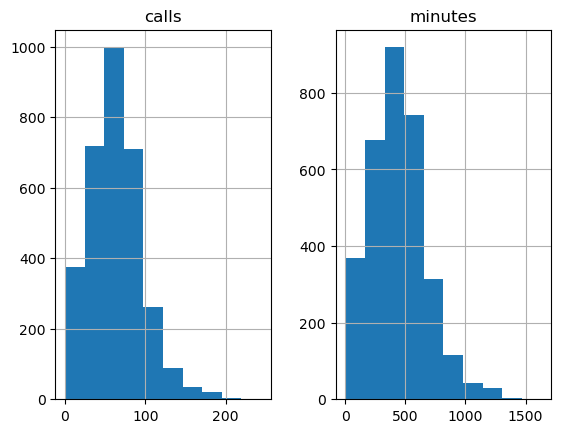

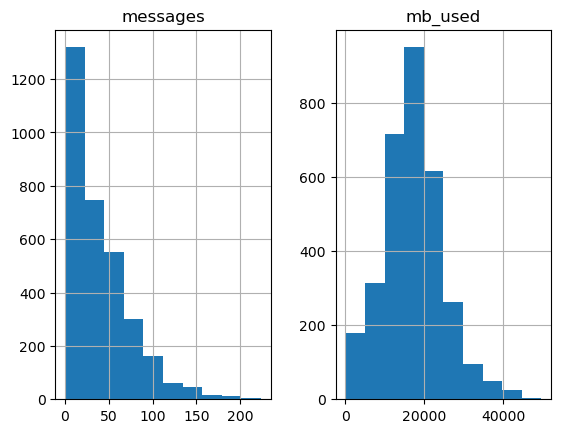

In [57]:
df.hist(column=['calls', 'minutes'])
df.hist(column=['messages', 'mb_used']);

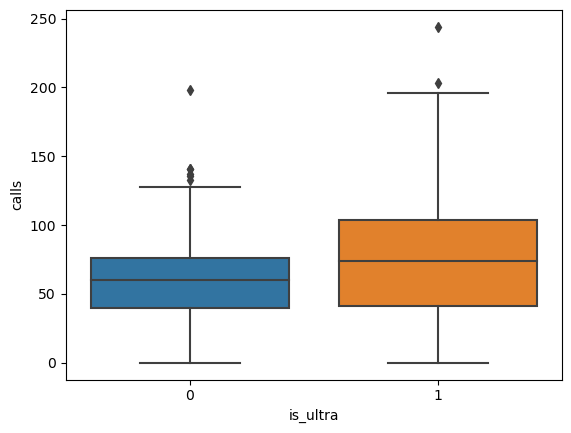

In [79]:
sns.boxplot(x='is_ultra', y='calls', data=df);

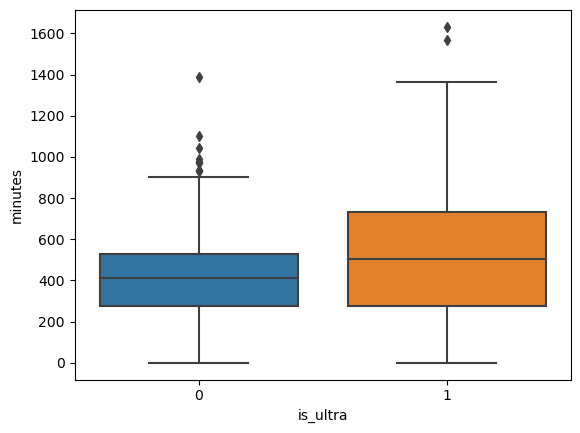

In [73]:
sns.boxplot(x='is_ultra', y='minutes', data=df);

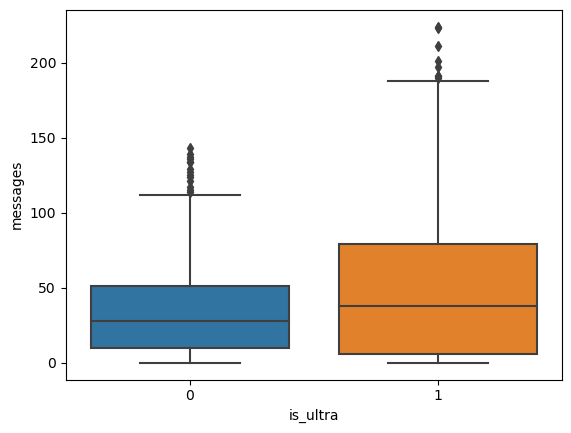

In [76]:
sns.boxplot(x='is_ultra', y='messages', data=df);

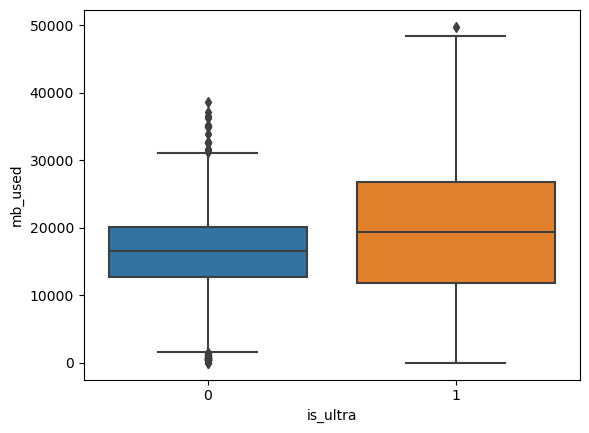

In [77]:
sns.boxplot(x='is_ultra', y='mb_used', data=df);

Overall, we see that users of the Ultra plan tend to make more calls, use more minutes, send more messages, and use more MB than users of the Smart plan.

# <span class="anchor" id="Modeling"> 5. Modeling</span>

As we are prediciting a category (Smart or Ultra plan), we have a classification problem. We'll try different classification models, evaluate them, and then select the one model that achieved the highest accuracy. The models we'll try are:

* Decision Tree
* Logistic Regression
* K-Nearest Neighbours Classifier
* Random Forest

In [14]:
# Split data into X and y
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']

# Set random seed for reproducible results
np.random.seed(42)

# Split data intro train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
# Put models in a dictionary
models = {"Decision tree": DecisionTreeClassifier(),
          "Logistic regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [16]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Decision tree': 0.7465007776049767,
 'Logistic regression': 0.7045101088646968,
 'KNN': 0.7978227060653188,
 'Random Forest': 0.8149300155520995}

## <span class="anchor" id="ModelComp"> 5.1 Model comparison</span>

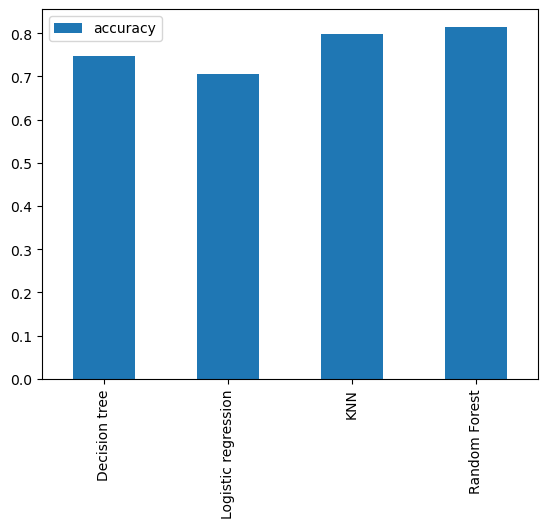

In [17]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

Now we have our baseline models. However, a model's first predictions aren't always what we should based our next steps on. Now, let us see if we can improve our models by changing their hyperparameters.

## <span class="anchor" id="Hyper"> 5.2 Hyperparameter tuning</span>

### Decision tree

In [18]:
# Create a hyperparameter grid for DecisionTree
dt_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2)
}

# Seed for reproducible results
np.random.seed(42)

# Hyperparameter search for DecisionTree
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(),
                                param_distributions=dt_grid,
                                cv=5,
                                n_iter=20)

# Fit random hyperparameter search model
rs_dt.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])})

In [19]:
rs_dt.score(X_test, y_test)

0.7869362363919129

The model improved, from 74% to 78% with randomized search hyperparameter tuning.

### KNN

In [20]:
train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1,21)

# Instantiate a KNN classifier
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for neighbor in neighbors:
    knn.set_params(n_neighbors=neighbor)
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update train_scores list
    train_scores.append(knn.score(X_train, y_train))
    
    # Update test_scores list
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 80.72%


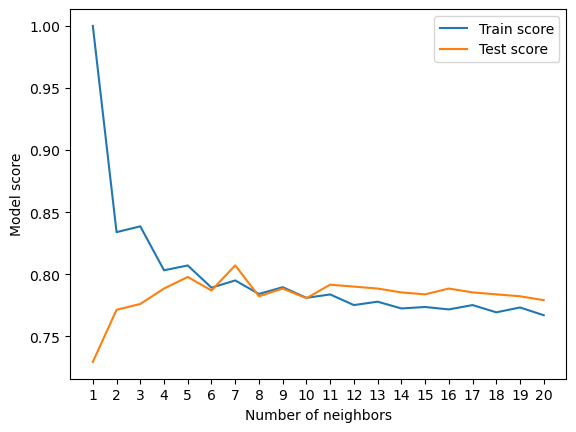

In [21]:
plt.plot(neighbors, train_scores, label='Train score')
plt.plot(neighbors, test_scores, label='Test score')
plt.xticks(np.arange(1,21,1))
plt.xlabel('Number of neighbors')
plt.ylabel('Model score')
plt.legend()

print(f'Maximum KNN score on the test data: {max(test_scores)*100:.2f}%')

The baseline model (no hyperparameter tuning) for KNN got an accuracy of 79.7%, and after the tuning it reached 80.7%. It improved after the tuning.

### Logistic regression

In [22]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
}

# Set random seed for reproducible results
np.random.seed(42)

# Hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [23]:
rs_log_reg.score(X_test, y_test)

0.7091757387247278

The model performed as about the same as the baseline version.

### Random Forest

In [24]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {
    'n_estimators': np.arange(10, 1000, 50),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2)
}

# Set random seed for reproducible results
np.random.seed(42)

# Hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rf_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [25]:
rs_rf.best_params_

{'n_estimators': 460,
 'min_samples_split': 6,
 'min_samples_leaf': 9,
 'max_depth': None}

In [26]:
rs_rf.score(X_test, y_test)

0.8087091757387247

The model now performed a little poorer than the baseline version. After looking at the tuned versions of our classifiers, we will choose the Random Forest, because it performed better, and we will try Grid Search in hope of getting a better version of it.

## <span class="anchor" id="HyperGS"> 5.3 Hyperparameter tuning with GridSearchCV</span>

In [18]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {
    'n_estimators': np.arange(100, 1000, 50),
    'max_depth': [None, 3, 5, 10],
}

In [19]:
# Hyperparameter search
gs_rf = GridSearchCV(RandomForestClassifier(),
                     param_grid=rf_grid,
                     cv=5,
                     verbose=True)

# Fit hyperparatemer search model
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5, 10],
                         'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950])},
             verbose=True)

In [20]:
gs_rf.score(X_test, y_test)

0.8180404354587869

We see a tiny improvement of the model (from 81.4% to 81.6%). We will then obtain the parameters that gave us this improved model and use them to obtain our final model.

In [21]:
# Getting the parameters of the improved model
gs_rf.best_params_

{'max_depth': 10, 'n_estimators': 700}

## <span class="anchor" id="ModelConclu"> 5.4. Modeling conclusions</span>

Based on our results, the Logistic Regression classifier performed below the evaluation threshold of 75% accuracy. The Decision Tree classifier improved after tuning, but it was below KNN and Random Forest. Although the KNN and the Random Forest classifiers had similar performance, we'll choose the Random Forest classifier as our model for this project given that it was the model with the highest accuracy.

# <span class="anchor" id="Final"> 6. Final model</span>

We'll use a Random Forest classifier with the hyperparameters tuned as obtained before.

In [22]:
# Set random seed for reproducible results
np.random.seed(42)

# Instantiate our model
final_model = RandomForestClassifier(n_estimators=350, max_depth=10)

# Fitting the model to the data
final_model.fit(X_train, y_train)

# Obtaining the predictions
y_preds = final_model.predict(X_test)

Now, let us look at a confusion matrix to check our model's predictions.

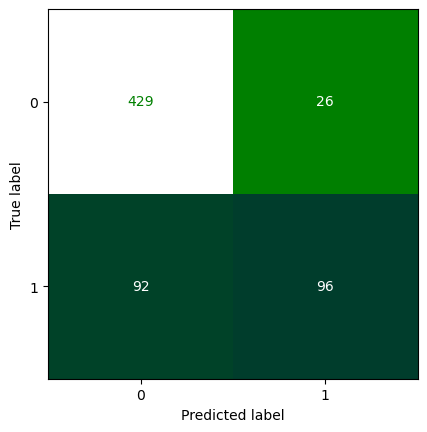

In [23]:
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test, cmap='ocean', colorbar=False);

So, our model:

* Correctly classified 429 as users of Smart plan.
* Correctly classified 96 as users of Ultra plan.
* Incorrectly classified 92 as users of Smart plan, when they actually use Ultra plan.
* Incorrectly classified 26 as users of Ultra plan, when they actually use Smart plan.

Now, let us plot a ROC curve in order to also to have an idea of how the model performs compared to simply guessing.

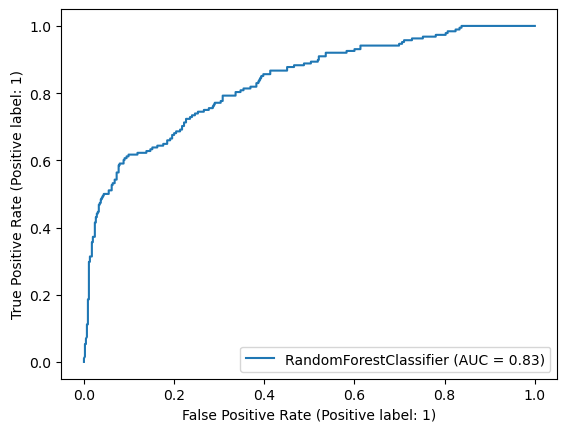

In [24]:
# Plotting ROC curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test);

Our model performs better than simple guessing as expressed by the curve. Guessing represents an area under the curve (AUC) of 0.5, that is, 50% of chance of correctly classify an observation. Our model performs at 83%, meaning that there's a 83% chance our model will correctly classify an observation.

We can also make the sanity check by instantiating a dummy classifier, i.e., a classifier that in this case generates predictions at random, assigning an equal probability to our classes of 1 and 0 in our target variable.

In [42]:
# Seed for reproducible results
np.random.seed(42)

# Creating a dummy classifier
dummy_clf = DummyClassifier(strategy='uniform')

# Fitting the dummy classifier to the data
dummy_clf.fit(X_train, y_train)

# Obtaining the score for the dummy classifier

dummy_clf.score(X_test, y_test)

0.49300155520995337

As we can see, our model performs better than a dummy classifier that simply guesses the labels.

# <span class="anchor" id="Conclusion"> 7. Conclusion</span>

After examinig the data give to us and finding no issues, we proceeded to make machine learning models in order to obtain a model that classifies users as member of the Smart or the Ultra plan. We set our threshold for success at 75% accuracy.

We tried different classification models: Decision Tree, Logistic regression, K-Nearest neighbors, and Random Forest. First, we trained each model without any improvement, that is, we trained the models with the default parameters as given by the library Scikit-learn.

After having our first results, we proceeded to tune each model by changing the hyperparameters to see if there was any improvement. After each tuning, we concluded that we will choose a Random Forest classifier, given it was the model that achieved the highest accuracy.

After choosing our model, we tried to improve it even more by using a Grid Search Cross Validation technique, to try different hyperparameters and their combinations. After this tuning, we obtained the hyperparameters that gave us the best Random Forest classifier of them all.

We then created a final model with a Random Forest clasifier and with the hyperparameters obtained after the Grid Search tuning. The model achieved an 83% of accuracy. Higher than our lower bound of 75%, but still not optimal as the model mismatches some observations. With more data, perhaps we could achieve more accuracy.